# 1.0 EDA & Data Splits

This notebook:
1. Verifies environment and paths.  
2. Loads IMDB and Rotten Tomatoes datasets.
3. Computes summary statistics.  
4. Creates seeded 80/10/10 train/val/test splits.  
5. Saves split indices to `data/splits/` and summary tables to `results/tables/`

In [46]:
# Config & paths
import json, os, yaml, random, platform, sys
from pathlib import Path

DEFAULT_CFG = {
    "dataset_imdb": "imdb",
    "dataset_rotten_tomatoes": "rotten_tomatoes",
    "val_size": 0.10,
    "test_size": 0.10,
    "seed": 42,
    "max_samples": None,
    "output_tables": "results/tables",
    "output_figures": "results/figures",
    "output_splits": "data/splits",
}

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "configs").exists() or (p / "src").exists() or (p / ".git").exists():
            return p
    return start

# Start from the notebook cwd
NOTEBOOK_CWD = Path.cwd()
ROOT = find_repo_root(NOTEBOOK_CWD)

if ROOT.name == "notebooks":
    ROOT = ROOT.parent

CFG_PATH = ROOT / "configs" / "data.yaml"

if CFG_PATH.exists():
    with open(CFG_PATH, "r") as f:
        CFG = {**DEFAULT_CFG, **yaml.safe_load(f)}
else:
    print("configs/data.yaml not found at:", CFG_PATH, "— using defaults.")
    CFG = DEFAULT_CFG

DIR_TABLES = ROOT / Path(CFG["output_tables"])
DIR_FIGS   = ROOT / Path(CFG["output_figures"])
DIR_SPLITS = ROOT / Path(CFG["output_splits"])
for p in (DIR_TABLES, DIR_FIGS, DIR_SPLITS):
    p.mkdir(parents=True, exist_ok=True)

print("Python:", sys.version)
print("Platform:", platform.platform())
print("Notebook CWD:", NOTEBOOK_CWD)
print("Project ROOT:", ROOT)
print("Config path:", CFG_PATH)
print("Tables ->", DIR_TABLES)
print("Figures ->", DIR_FIGS)
print("Splits  ->", DIR_SPLITS)


Python: 3.13.2 (v3.13.2:4f8bb3947cf, Feb  4 2025, 11:51:10) [Clang 15.0.0 (clang-1500.3.9.4)]
Platform: macOS-15.6.1-arm64-arm-64bit-Mach-O
Notebook CWD: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/notebooks
Project ROOT: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project
Config path: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/configs/data.yaml
Tables -> /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/tables
Figures -> /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/figures
Splits  -> /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/data/splits


In [47]:
# %% Imports & deterministic seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(CFG["seed"])

In [48]:
# Load datasets
from datasets import load_dataset

ds_imdb = load_dataset(CFG["dataset_imdb"])            # splits: train, test, unsupervised
ds_rt   = load_dataset(CFG["dataset_rotten_tomatoes"]) # splits: train, validation, test

def to_df(ds, text_key="text", label_key="label"):
    return pd.DataFrame({"text": ds[text_key], "label": ds[label_key]})

# IMDB
imdb_train = to_df(ds_imdb["train"])
imdb_test  = to_df(ds_imdb["test"])

# RT
rt_train = to_df(ds_rt["train"])
rt_val   = to_df(ds_rt["validation"])
rt_test  = to_df(ds_rt["test"])

max_samples = CFG.get("max_samples")
rs = CFG["seed"]
if max_samples:
    imdb_train = imdb_train.sample(n=min(max_samples, len(imdb_train)), random_state=rs)
    imdb_test  = imdb_test.sample(n=min(max_samples, len(imdb_test)), random_state=rs)
    rt_train   = rt_train.sample(n=min(max_samples, len(rt_train)), random_state=rs)
    rt_val     = rt_val.sample(n=min(max_samples, len(rt_val)), random_state=rs)
    rt_test    = rt_test.sample(n=min(max_samples, len(rt_test)), random_state=rs)

print("IMDB:", {k: len(v) for k, v in {"train": imdb_train, "test": imdb_test}.items()})
print("RT  :", {k: len(v) for k, v in {"train": rt_train, "val": rt_val, "test": rt_test}.items()})


IMDB: {'train': 25000, 'test': 25000}
RT  : {'train': 8530, 'val': 1066, 'test': 1066}


In [49]:
# Minimal normalisation + length features
def normalize_text(s: str) -> str:
    return " ".join(str(s).split())

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["text_norm"] = df["text"].map(normalize_text)
    df["len_chars"] = df["text_norm"].map(len)
    df["len_words"] = df["text_norm"].map(lambda x: len(x.split()))
    return df

imdb_train_f = add_features(imdb_train)
imdb_test_f  = add_features(imdb_test)
rt_train_f   = add_features(rt_train)
rt_val_f     = add_features(rt_val)
rt_test_f    = add_features(rt_test)

In [50]:
# Summary tables
def label_balance(df: pd.DataFrame, name: str):
    counts = df["label"].value_counts().sort_index()
    pct = counts / counts.sum()
    out = pd.DataFrame({"count": counts, "ratio": pct})
    out.index.name = "label"
    out.reset_index(inplace=True)
    out["split"] = name
    return out[["split", "label", "count", "ratio"]]

label_balance_tbl = pd.concat(
    [
        label_balance(imdb_train_f, "imdb_train"),
        label_balance(imdb_test_f,  "imdb_test"),
        label_balance(rt_train_f,   "rt_train"),
        label_balance(rt_val_f,     "rt_val"),
        label_balance(rt_test_f,    "rt_test"),
    ],
    ignore_index=True
)
label_balance_path = DIR_TABLES / "label_balance.csv"
label_balance_tbl.to_csv(label_balance_path, index=False)

def length_stats(df: pd.DataFrame, name: str):
    return pd.Series({
        "split": name,
        "n": len(df),
        "len_chars_mean": df["len_chars"].mean(),
        "len_chars_median": df["len_chars"].median(),
        "len_words_mean": df["len_words"].mean(),
        "len_words_median": df["len_words"].median(),
    })

length_stats_tbl = pd.DataFrame(
    [
        length_stats(imdb_train_f, "imdb_train"),
        length_stats(imdb_test_f,  "imdb_test"),
        length_stats(rt_train_f,   "rt_train"),
        length_stats(rt_val_f,     "rt_val"),
        length_stats(rt_test_f,    "rt_test"),
    ]
)
length_stats_path = DIR_TABLES / "length_stats.csv"
length_stats_tbl.to_csv(length_stats_path, index=False)

print("Saved tables:")
print(" -", label_balance_path)
print(" -", length_stats_path)

label_balance_tbl.head(), length_stats_tbl.head()


Saved tables:
 - /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/tables/label_balance.csv
 - /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/tables/length_stats.csv


(        split  label  count  ratio
 0  imdb_train      0  12500    0.5
 1  imdb_train      1  12500    0.5
 2   imdb_test      0  12500    0.5
 3   imdb_test      1  12500    0.5
 4    rt_train      0   4265    0.5,
         split      n  len_chars_mean  len_chars_median  len_words_mean  \
 0  imdb_train  25000     1325.049720             979.0      233.787200   
 1   imdb_test  25000     1293.769160             962.0      228.526680   
 2    rt_train   8530      113.970340             111.0       20.992849   
 3      rt_val   1066      114.293621             112.0       20.997186   
 4     rt_test   1066      115.520638             113.0       21.220450   
 
    len_words_median  
 0             174.0  
 1             172.0  
 2              20.0  
 3              21.0  
 4              20.0  )

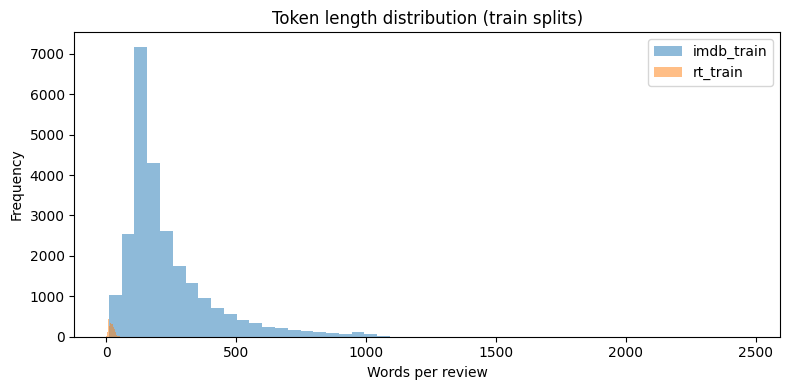

Saved figure: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/results/figures/length_hist_train.png


In [51]:
# Plot
plt.figure(figsize=(8, 4))
imdb_train_f["len_words"].plot(kind="hist", bins=50, alpha=0.5, label="imdb_train")
rt_train_f["len_words"].plot(kind="hist", bins=50, alpha=0.5, label="rt_train")
plt.title("Token length distribution (train splits)")
plt.xlabel("Words per review")
plt.ylabel("Frequency")
plt.legend()
fig_path = DIR_FIGS / "length_hist_train.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved figure:", fig_path)


In [52]:
# Build unified 80/10/10 splits from full sets
from sklearn.model_selection import train_test_split

def stratified_splits(df: pd.DataFrame, seed: int, val_size=0.1, test_size=0.1):
    X = df.index.values
    y = df["label"].values

    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        X, y,
        test_size=val_size + test_size,
        stratify=y,
        random_state=seed
    )

    rel_test = test_size / (val_size + test_size)
    X_val, X_te, y_val, y_te = train_test_split(
        X_tmp, y_tmp,
        test_size=rel_test,
        stratify=y_tmp,
        random_state=seed
    )
    return X_tr.tolist(), X_val.tolist(), X_te.tolist()

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

# Recombine official splits to form full datasets, then re-split 80/10/10
imdb_full = pd.concat([imdb_train_f, imdb_test_f], ignore_index=True)
rt_full   = pd.concat([rt_train_f, rt_val_f, rt_test_f], ignore_index=True)

seed = CFG["seed"]
vsize = float(CFG["val_size"])
tsize = float(CFG["test_size"])

imdb_tr, imdb_va, imdb_te = stratified_splits(imdb_full, seed, vsize, tsize)
rt_tr,   rt_va,   rt_te   = stratified_splits(rt_full,   seed, vsize, tsize)

save_json({"train": imdb_tr, "val": imdb_va, "test": imdb_te}, DIR_SPLITS / "imdb_indices.json")
save_json({"train": rt_tr,   "val": rt_va,   "test": rt_te},   DIR_SPLITS / "rt_indices.json")

# Save CSV previews
pd.DataFrame({"idx": imdb_tr}).to_csv(DIR_SPLITS / "imdb_train_idx.csv", index=False)
pd.DataFrame({"idx": imdb_va}).to_csv(DIR_SPLITS / "imdb_val_idx.csv", index=False)
pd.DataFrame({"idx": imdb_te}).to_csv(DIR_SPLITS / "imdb_test_idx.csv", index=False)
pd.DataFrame({"idx": rt_tr}).to_csv(DIR_SPLITS / "rt_train_idx.csv", index=False)
pd.DataFrame({"idx": rt_va}).to_csv(DIR_SPLITS / "rt_val_idx.csv", index=False)
pd.DataFrame({"idx": rt_te}).to_csv(DIR_SPLITS / "rt_test_idx.csv", index=False)

print("Saved unified splits to:", DIR_SPLITS)


Saved unified splits to: /Users/jasmine/Desktop/01 DSA4213/Project/dsa4213project/data/splits
